<a href="https://colab.research.google.com/github/FatmaBuseBorlu/YuzGoruntulerindenDuyguTanimaveTepkiVerme/blob/main/Yapay_Zeka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Eğitim ve test veri yolları
train_dir = "/content/drive/MyDrive/Yapay Zeka Bilişsel Sİstemler Dersi Proje/RAF-DB-DATASET/DATASET/train"
test_dir = "/content/drive/MyDrive/Yapay Zeka Bilişsel Sİstemler Dersi Proje/RAF-DB-DATASET/DATASET/test"

In [ ]:
# Eğitim ve test verilerinin yüklenmesi
def load_data(directory):
    X, y = [], []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for image_name in os.listdir(label_path):
                image_path = os.path.join(label_path, image_name)
                img = load_img(image_path, target_size=(224, 224))  # Görüntüyü yeniden boyutlandır
                img_array = img_to_array(img)  # NumPy formatına çevir
                img_array = preprocess_input(img_array)  # MobileNetV2 için ön işleme
                X.append(img_array)
                y.append(int(label))  # Klasör adı etikettir
    return np.array(X), np.array(y)

X_train, y_train = load_data(train_dir)
X_test, y_test = load_data(test_dir)

In [ ]:
# Etiketleri 0'dan başlatma
y_train -= 1
y_test -= 1

# Sınıf sayısını belirleme
num_classes = len(np.unique(y_train))

# Etiketleri kategorik hale getirme
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(f"Eğitim verileri: {X_train.shape}, Etiketler: {y_train.shape}")
print(f"Test verileri: {X_test.shape}, Etiketler: {y_test.shape}")


In [ ]:
# Veri artırma işlemi
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

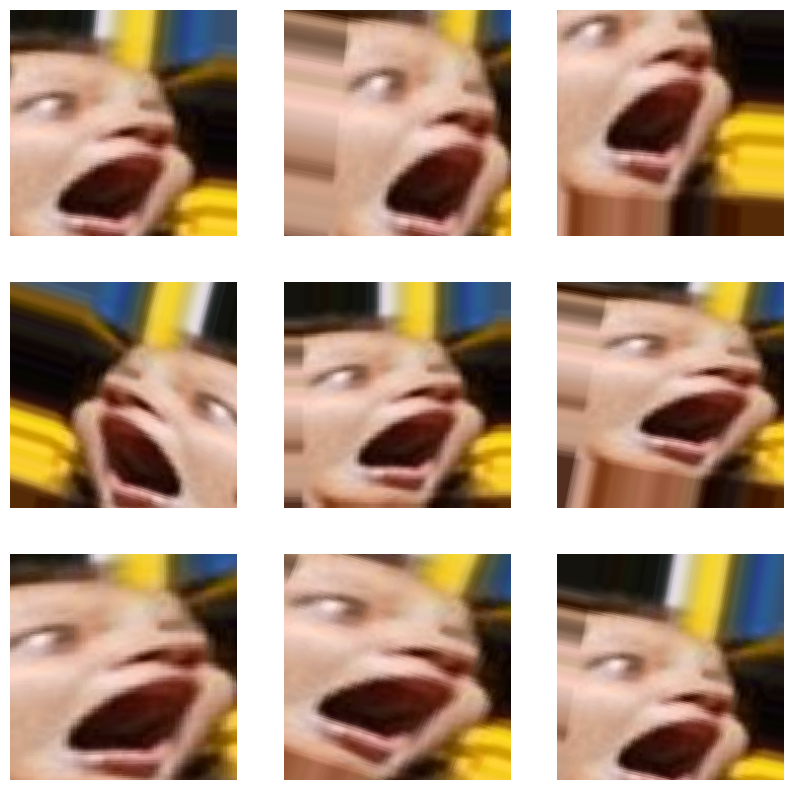

2 sınıfı için 100 artırılmış görüntü başarıyla oluşturuldu.


In [ ]:
# Veri artırma işlemi için bir ImageDataGenerator oluşturma
data_augmentation = ImageDataGenerator(
    rotation_range=20,         # Görüntüyü döndürme (derece cinsinden)
    width_shift_range=0.2,     # Görüntüyü yatay kaydırma
    height_shift_range=0.2,    # Görüntüyü dikey kaydırma
    shear_range=0.2,           # Şeritleme (shearing)
    zoom_range=0.2,            # Yakınlaştırma
    horizontal_flip=True,      # Yatay çevirme
    fill_mode="nearest"        # Yeni pikseller için dolgu modu
)

# Eğitim veri setinden az örnekli sınıflardan birini artırma örneği
class_to_augment = "2"  # Az örnekli bir sınıf
augment_dir = os.path.join(train_dir, class_to_augment)

augmented_images = []
augmented_labels = []

for image_name in os.listdir(augment_dir):
    image_path = os.path.join(augment_dir, image_name)
    img = load_img(image_path, target_size=(224, 224))  # Görüntüyü yükle ve yeniden boyutlandır
    img_array = img_to_array(img)  # NumPy dizisine çevir
    img_array = np.expand_dims(img_array, axis=0)  # Veri artırma için batch formatına dönüştür

    # Veri artırma işlemi
    i = 0
    for batch in data_augmentation.flow(img_array, batch_size=1):
        augmented_images.append(batch[0])  # Artırılmış görüntüyü kaydet
        augmented_labels.append(int(class_to_augment))  # Sınıf etiketini kaydet
        i += 1
        if i >= 100:  # Her görüntü için 100 artırma oluştur
            break

# Yeni artırılmış veriyi görselleştirme
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].astype("uint8"))
    plt.axis("off")
plt.show()

print(f"{class_to_augment} sınıfı için 100 artırılmış görüntü başarıyla oluşturuldu.")


In [ ]:
# Google Drive'da ana klasör yolu
train_dir = "/content/drive/MyDrive/Yapay Zeka Bilişsel Sİstemler Dersi Proje/RAF-DB-DATASET/DATASET/train"
test_dir = "/content/drive/MyDrive/Yapay Zeka Bilişsel Sİstemler Dersi Proje/RAF-DB-DATASET/DATASET/test"

# Eğitim ve test verilerini depolamak için boş listeler
X_train, y_train = [], []
X_test, y_test = [], []

# Eğitim verilerini yükleme
for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)  # Alt klasör yolu
    if os.path.isdir(label_path):  # Klasör olup olmadığını kontrol et
        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)
            img = load_img(image_path, target_size=(224, 224))  # Görüntüyü yeniden boyutlandır
            img_array = img_to_array(img) / 255.0  # Normalizasyon
            X_train.append(img_array)
            y_train.append(int(label))  # Klasör adı etikettir

# Test verilerini yükleme
for label in os.listdir(test_dir):
    label_path = os.path.join(test_dir, label)
    if os.path.isdir(label_path):
        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)
            img = load_img(image_path, target_size=(224, 224))
            img_array = img_to_array(img) / 255.0
            X_test.append(img_array)
            y_test.append(int(label))

# Numpy formatına dönüştürme
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Eğitim verileri: {X_train.shape}, Etiketler: {y_train.shape}")
print(f"Test verileri: {X_test.shape}, Etiketler: {y_test.shape}")


Eğitim verileri: (12271, 224, 224, 3), Etiketler: (12271,)
Test verileri: (3068, 224, 224, 3), Etiketler: (3068,)


In [ ]:
# Etiketleri 0'dan başlatma
y_train = y_train - 1
y_test = y_test - 1

print("0'dan Başlatılmış Eğitim Etiketleri (y_train):", np.unique(y_train))
print("0'dan Başlatılmış Test Etiketleri (y_test):", np.unique(y_test))


0'dan Başlatılmış Eğitim Etiketleri (y_train): [0 1 2 3 4 5 6]
0'dan Başlatılmış Test Etiketleri (y_test): [0 1 2 3 4 5 6]


In [ ]:
# Sınıf sayısını yeniden kontrol et
num_classes = len(np.unique(y_train))

# Etiketleri kategorik hale getirme
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print("Kategorik Eğitim Etiketleri (y_train):", y_train.shape)
print("Kategorik Test Etiketleri (y_test):", y_test.shape)

Kategorik Eğitim Etiketleri (y_train): (12271, 7)
Kategorik Test Etiketleri (y_test): (3068, 7)


In [ ]:
# Model oluşturma
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Overfitting'i azaltmak için Dropout kullanıyoruz
    Dense(7, activation='softmax')  # 7 duygu sınıfı için çıkış katmanı
])

# Modeli derleme
loss = CategoricalCrossentropy(label_smoothing=0.1)
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])


# Model özeti
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,863 (42.61 MB)

 Trainable params: 11,169,863 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# One-hot encoded etiketleri düz bir listeye dönüştürme
y_train_labels = np.argmax(y_train, axis=1)  # Kategorik etiketleri düz bir listeye çevir

# Sınıf ağırlıklarını hesaplama
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),  # 0'dan başlayan sınıflar
    y=y_train_labels  # Etiketlerin düz bir hali
)

# Sınıf ağırlıklarını sözlüğe dönüştürme
class_weights = dict(enumerate(class_weights_array))
print("Sınıf Ağırlıkları (Sözlük):", class_weights)

# Modeli yeniden eğitme
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights  # Sınıf ağırlıklarını ekleme
)

# Eğitilen modeli kaydetme
model.save("emotion_recognition_model.h5")

Sınıf Ağırlıkları (Sözlük): {0: 1.3589147286821706, 1: 6.238434163701068, 2: 2.4449093444909344, 3: 0.3673512154233026, 4: 0.884460141271443, 5: 2.4865248226950354, 6: 0.6945324881141046}
Epoch 1/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 319s 827ms/step - accuracy: 0.2591 - loss: 1.9839 - val_accuracy: 0.4306 - val_loss: 1.8171
Epoch 2/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 325s 846ms/step - accuracy: 0.4188 - loss: 1.7239 - val_accuracy: 0.5508 - val_loss: 1.4888
Epoch 3/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 314s 818ms/step - accuracy: 0.5260 - loss: 1.4902 - val_accuracy: 0.6115 - val_loss: 1.3311
Epoch 4/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 310s 807ms/step - accuracy: 0.5849 - loss: 1.3816 - val_accuracy: 0.6327 - val_loss: 1.2399
Epoch 5/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 309s 805ms/step - accuracy: 0.6084 - loss: 1.3081 - val_accuracy: 0.6460 - val_loss: 1.2400
Epoch 6/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 309s 804ms/step - accuracy: 0.6334 - loss: 1.2383 - val_accuracy: 0.6245 - val_loss: 1.2460
Epoch 7/10
384/384 ━

In [ ]:
# Modeli test etme
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Doğruluğu: {test_accuracy * 100:.2f}%")

96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - accuracy: 0.6516 - loss: 1.2019
Test Doğruluğu: 66.17%


Test edilecek görüntü: /content/drive/MyDrive/Yapay Zeka Bilişsel Sİstemler Dersi Proje/RAF-DB-DATASET/DATASET/test/4/test_0428_aligned.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


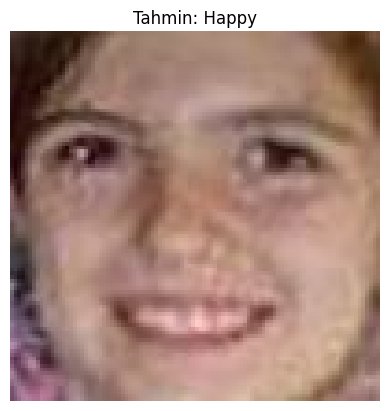

Modelin tahmini: Happy


In [ ]:
# Modeli yükleme
model = load_model("emotion_recognition_model.h5")

# Test CSV dosyasını yükleme
test_csv_path = "/content/drive/MyDrive/Yapay Zeka Bilişsel Sİstemler Dersi Proje/RAF-DB-DATASET/test_labels.csv"
test_data = pd.read_csv(test_csv_path)

# Rastgele bir görüntü seçme
random_row = test_data.sample(n=1).iloc[0]
test_image_name = random_row['image']
correct_label = random_row['label']

# Görüntü yolunu oluşturma
test_image_path = os.path.join("/content/drive/MyDrive/Yapay Zeka Bilişsel Sİstemler Dersi Proje/RAF-DB-DATASET/DATASET/test", str(correct_label), test_image_name)
print(f"Test edilecek görüntü: {test_image_path}")

# Görüntüyü yükleme ve işleme
img = load_img(test_image_path, target_size=(224, 224))  # Görüntüyü yükle ve boyutlandır
img_array = img_to_array(img) / 255.0  # Normalizasyon
img_array = np.expand_dims(img_array, axis=0)  # Modelin tahmini için batch boyutuna dönüştür

# Görüntü üzerinde tahmin yapma
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)

# Sınıf etiketleri
emotion_labels = {0: "Surprise", 1: "Fear", 2: "Disgust", 3: "Happy", 4: "Sad", 5: "Anger", 6: "Neutral"}
predicted_label = emotion_labels[predicted_class]

# Tahminin görselleştirilmesi
plt.imshow(load_img(test_image_path))  # Görüntüyü yükleyerek görselleştir
plt.title(f"Tahmin: {predicted_label}")
plt.axis("off")
plt.show()

print(f"Modelin tahmini: {predicted_label}")


In [ ]:
# Tüm test verileri için tahmin yapma
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Sınıflandırma raporu
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes))


96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 193ms/step
Confusion Matrix:
 [[235  10  21  12  10  11  30]
 [ 14  31   6   8   4   6   5]
 [  4   2  86  14  13  16  25]
 [ 30  10  75 933  60  20  57]
 [ 24   9  50  45 241  21  88]
 [  9   8  19  11   5  98  12]
 [ 37  10  99  36  73  19 406]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.71      0.69       329
           1       0.39      0.42      0.40        74
           2       0.24      0.54      0.33       160
           3       0.88      0.79      0.83      1185
           4       0.59      0.50      0.55       478
           5       0.51      0.60      0.56       162
           6       0.65      0.60      0.62       680

    accuracy                           0.66      3068
   macro avg       0.56      0.59      0.57      3068
weighted avg       0.70      0.66      0.67      3068

